# Quantifying uncertainty in weather data
CityLearn comes with several dimenstions of weather data. Namely: actual hourly measurements as well as 6-,12-, and 24-hour point estimate forecasts for Outdoor Drybulb Temperature, Relative Humidity, Diffuse and Direct Solar Radiation.

The goal of this subproject is to identify the distributions of these point estimates, giving us the opportunity to know when to rely how much on these forecasts.

## Loading the Data

In [188]:
# canonical imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# let's read in the data (this would probably be easier in SQL, but I don't want to set up a database)
weather = pd.read_csv("../data/citylearn_challenge_2022_phase_1/weather.csv")
# the buildings contain per-row time data
building1 = pd.read_csv("../data/citylearn_challenge_2022_phase_1/Building_1.csv")
building2 = pd.read_csv("../data/citylearn_challenge_2022_phase_1/Building_2.csv")
building3 = pd.read_csv("../data/citylearn_challenge_2022_phase_1/Building_3.csv")
building4 = pd.read_csv("../data/citylearn_challenge_2022_phase_1/Building_4.csv")
building5 = pd.read_csv("../data/citylearn_challenge_2022_phase_1/Building_5.csv")
buildings = [building1, building2, building3, building4, building5]

pricing = pd.read_csv("../data/citylearn_challenge_2022_phase_1/pricing.csv")
co2 = pd.read_csv("../data/citylearn_challenge_2022_phase_1/carbon_intensity.csv")


In [189]:
# let's look at the weather data
weather

,Outdoor Drybulb Temperature [C],Relative Humidity [%],Diffuse Solar Radiation [W/m2],Direct Solar Radiation [W/m2],6h Prediction Outdoor Drybulb Temperature [C],12h Prediction Outdoor Drybulb Temperature [C],24h Prediction Outdoor Drybulb Temperature [C],6h Prediction Relative Humidity [%],12h Prediction Relative Humidity [%],24h Prediction Relative Humidity [%],6h Prediction Diffuse Solar Radiation [W/m2],12h Prediction Diffuse Solar Radiation [W/m2],24h Prediction Diffuse Solar Radiation [W/m2],6h Prediction Direct Solar Radiation [W/m2],12h Prediction Direct Solar Radiation [W/m2],24h Prediction Direct Solar Radiation [W/m2]
0,20.0,84.0,0.0,0.0,18.3,22.8,20.0,81.0,68.0,81.0,25.0,964.0,0.0,100.0,815.0,0.0
1,20.1,79.0,0.0,0.0,19.4,22.8,19.4,79.0,71.0,87.0,201.0,966.0,0.0,444.0,747.0,0.0
2,19.7,78.0,0.0,0.0,21.1,22.2,19.4,73.0,73.0,87.0,420.0,683.0,0.0,592.0,291.0,0.0
3,19.3,78.0,0.0,0.0,22.2,22.8,19.4,71.0,71.0,90.0,554.0,522.0,0.0,491.0,153.0,0.0
4,18.9,78.0,0.0,0.0,21.7,22.2,18.9,73.0,71.0,90.0,778.0,444.0,0.0,734.0,174.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,20.6,84.0,26.0,130.0,20.1,19.4,20.6,79.0,79.0,73.0,0.0,201.0,27.0,0.0,444.0,143.0
8756,21.1,81.0,0.0,0.0,19.7,21.1,20.0,78.0,73.0,76.0,0.0,420.0,0.0,0.0,592.0,0.0
8757,21.7,79.0,0.0,0.0,19.3,22.2,20.6,78.0,71.0,70.0,0.0,554.0,0.0,0.0,491.0,0.0
8758,21.3,76.0,0.0,0.0,18.9,21.7,20.6,78.0,73.0,73.0,0.0,778.0,0.0,0.0,734.0,0.0


In [190]:
# Let's declare some helper variables to deal with the column names
pred_6 = "6h Prediction "
pred_12 = "12h Prediction "
pred_24 = "24h Prediction "

true_6 = "6h Lookahead "
true_12 = "12h Lookahead "
true_24 = "24h Lookahead "

temperature = "Outdoor Drybulb Temperature [C]"
humidity = "Relative Humidity [%]"
diffuse = "Diffuse Solar Radiation [W/m2]"
direct = "Direct Solar Radiation [W/m2]"
measures = [temperature, humidity, diffuse, direct]

# quick sanity check
assert pred_6+temperature == "6h Prediction Outdoor Drybulb Temperature [C]"

In [191]:
# Next, let's integrate the date information from the building data.
# The next line shows us that we don't have to deal with Daylight Savings Time:
building1[building1["Daylight Savings Status"] != 0] # returns 0 rows

,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature [C],Average Unmet Cooling Setpoint Difference [C],Indoor Relative Humidity [%],Equipment Electric Power [kWh],DHW Heating [kWh],Cooling Load [kWh],Heating Load [kWh],Solar Generation [W/kW]


In [192]:
# This means we can omit this column, and simply add Month, Hour and Day Type to our weather dataframe:
weathertime = building1[["Month", "Hour", "Day Type"]].join(weather)
weathertime.head()

,Month,Hour,Day Type,Outdoor Drybulb Temperature [C],Relative Humidity [%],Diffuse Solar Radiation [W/m2],Direct Solar Radiation [W/m2],6h Prediction Outdoor Drybulb Temperature [C],12h Prediction Outdoor Drybulb Temperature [C],24h Prediction Outdoor Drybulb Temperature [C],6h Prediction Relative Humidity [%],12h Prediction Relative Humidity [%],24h Prediction Relative Humidity [%],6h Prediction Diffuse Solar Radiation [W/m2],12h Prediction Diffuse Solar Radiation [W/m2],24h Prediction Diffuse Solar Radiation [W/m2],6h Prediction Direct Solar Radiation [W/m2],12h Prediction Direct Solar Radiation [W/m2],24h Prediction Direct Solar Radiation [W/m2]
0,7.0,24.0,7.0,20.0,84.0,0.0,0.0,18.3,22.8,20.0,81.0,68.0,81.0,25.0,964.0,0.0,100.0,815.0,0.0
1,8.0,1.0,1.0,20.1,79.0,0.0,0.0,19.4,22.8,19.4,79.0,71.0,87.0,201.0,966.0,0.0,444.0,747.0,0.0
2,8.0,2.0,1.0,19.7,78.0,0.0,0.0,21.1,22.2,19.4,73.0,73.0,87.0,420.0,683.0,0.0,592.0,291.0,0.0
3,8.0,3.0,1.0,19.3,78.0,0.0,0.0,22.2,22.8,19.4,71.0,71.0,90.0,554.0,522.0,0.0,491.0,153.0,0.0
4,8.0,4.0,1.0,18.9,78.0,0.0,0.0,21.7,22.2,18.9,73.0,71.0,90.0,778.0,444.0,0.0,734.0,174.0,0.0


In [193]:
# Also, let's add the actual future values so we have something to compare the predictions to.
predictions = weathertime[:-24] #remove last day of predictions, which has no ground truth for 24h predicitons

ground_truth_6 = weathertime[measures][6:-18]
ground_truth_12 = weathertime[measures][12:-12]
ground_truth_24 = weathertime[measures][24:]

# a bit of shenanigans to reset the index and rename the columns
ground_truth_6 =  ground_truth_6.reset_index(drop=True )
ground_truth_12 = ground_truth_12.reset_index(drop=True)
ground_truth_24 = ground_truth_24.reset_index(drop=True)


ground_truth_6 =  ground_truth_6.rename(columns= (lambda lbl : true_6+lbl))
ground_truth_12 = ground_truth_12.rename(columns= (lambda lbl : true_12+lbl))
ground_truth_24 = ground_truth_24.rename(columns= (lambda lbl : true_24+lbl))


predictions = predictions.join([ground_truth_6, ground_truth_12, ground_truth_24])
predictions.head()

,Month,Hour,Day Type,Outdoor Drybulb Temperature [C],Relative Humidity [%],Diffuse Solar Radiation [W/m2],Direct Solar Radiation [W/m2],6h Prediction Outdoor Drybulb Temperature [C],12h Prediction Outdoor Drybulb Temperature [C],24h Prediction Outdoor Drybulb Temperature [C],...,6h Lookahead Diffuse Solar Radiation [W/m2],6h Lookahead Direct Solar Radiation [W/m2],12h Lookahead Outdoor Drybulb Temperature [C],12h Lookahead Relative Humidity [%],12h Lookahead Diffuse Solar Radiation [W/m2],12h Lookahead Direct Solar Radiation [W/m2],24h Lookahead Outdoor Drybulb Temperature [C],24h Lookahead Relative Humidity [%],24h Lookahead Diffuse Solar Radiation [W/m2],24h Lookahead Direct Solar Radiation [W/m2]
0,7.0,24.0,7.0,20.0,84.0,0.0,0.0,18.3,22.8,20.0,...,25.0,100.0,22.8,68.0,964.0,815.0,20.0,81.0,0.0,0.0
1,8.0,1.0,1.0,20.1,79.0,0.0,0.0,19.4,22.8,19.4,...,201.0,444.0,22.8,71.0,966.0,747.0,19.4,87.0,0.0,0.0
2,8.0,2.0,1.0,19.7,78.0,0.0,0.0,21.1,22.2,19.4,...,420.0,592.0,22.2,73.0,683.0,291.0,19.4,87.0,0.0,0.0
3,8.0,3.0,1.0,19.3,78.0,0.0,0.0,22.2,22.8,19.4,...,554.0,491.0,22.8,71.0,522.0,153.0,19.4,90.0,0.0,0.0
4,8.0,4.0,1.0,18.9,78.0,0.0,0.0,21.7,22.2,18.9,...,778.0,734.0,22.2,71.0,444.0,174.0,18.9,90.0,0.0,0.0


## Examine predictions and errors
Now that we have the data in a usable form, let's compare predictions with ground truths!

First, let's get the general distribution of prediction errors. Then we can slice them by hour of day to see if the distribution changes over time

In [194]:
for pred, true in zip([pred_6, pred_12, pred_24],[true_6, true_12, true_24]):
    for measure in measures:
        print(pred + measure + ": ", (predictions[pred + measure] != predictions[true + measure]).sum())
# APPARENTLY THE PREDICTIONS ARE JUST THE OBSERVATIONS! NICE ORACLE YOU HAVE THERE!

6h Prediction Outdoor Drybulb Temperature [C]:  0
6h Prediction Relative Humidity [%]:  0
6h Prediction Diffuse Solar Radiation [W/m2]:  0
6h Prediction Direct Solar Radiation [W/m2]:  0
12h Prediction Outdoor Drybulb Temperature [C]:  0
12h Prediction Relative Humidity [%]:  0
12h Prediction Diffuse Solar Radiation [W/m2]:  0
12h Prediction Direct Solar Radiation [W/m2]:  0
24h Prediction Outdoor Drybulb Temperature [C]:  0
24h Prediction Relative Humidity [%]:  0
24h Prediction Diffuse Solar Radiation [W/m2]:  0
24h Prediction Direct Solar Radiation [W/m2]:  0


Wow, this was much ado about nothing, I don't know why they would call them "predictions". Not sure why they would not use actual weather forecasts!

## Pricing and CO2

In [195]:
pricing.groupby("Electricity Pricing [$]").count()

,6h Prediction Electricity Pricing [$],12h Prediction Electricity Pricing [$],24h Prediction Electricity Pricing [$]
Electricity Pricing [$],,,
0.21,4617,4617,4617
0.22,2318,2318,2318
0.40,170,170,170
0.50,1215,1215,1215
0.54,440,440,440


In [196]:
co2

,kg_CO2/kWh
0,0.170724
1,0.157319
2,0.154503
3,0.150945
4,0.151820
...,...
8755,0.222553
8756,0.216094
8757,0.215501
8758,0.202315


In [197]:
pricingtime = pd.concat(objs=[building1[["Hour", "Month","Day Type"]], pricing["Electricity Pricing [$]"], co2],
                        axis="columns")
#pricingtime.groupby("Hour").mean()
print(np.corrcoef(pricingtime["Electricity Pricing [$]"], pricingtime["kg_CO2/kWh"]))

pricingtime.groupby(["Electricity Pricing [$]", "Month"]).count()


[[1.         0.31301315]
 [0.31301315 1.        ]]


Hour  Day Type  kg_CO2/kWh
Electricity Pricing [$] Month                            
0.21                    1.0     589       589         589
                        2.0     532       532         532
                        3.0     589       589         589
                        4.0     570       570         570
                        5.0     588       588         588
                        9.0       1         1           1
                        10.0    589       589         589
                        11.0    570       570         570
                        12.0    589       589         589
0.22                    5.0       1         1           1
                        6.0     570       570         570
                        7.0     589       589         589
                        8.0     589       589         589
                        9.0     569       569         569
0.40                    6.0      40        40          40
                        7.0      50        50          50
                        8.0      40        40          40
                        9.0      40        40          40
0.50                    1.0     155       155         155
                        2.0     140       140         140
                        3.0     155       155         155
                        4.0     150       150         150
                        5.0     155       155         155
                        10.0    155       155         155
                        11.0    150       150         150
                        12.0    155       155         155
0.54                    6.0     110       110         110
                        7.0     105       105         105
                        8.0     115       115         115
                        9.0     110       110         110

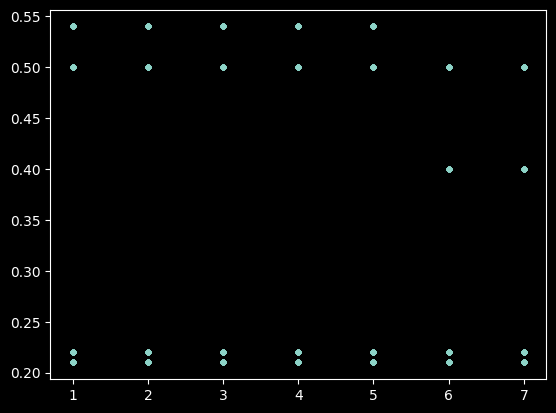

In [198]:
# The prices vary through the week:
plt.plot(pricingtime["Day Type"], pricingtime["Electricity Pricing [$]"] , ".")

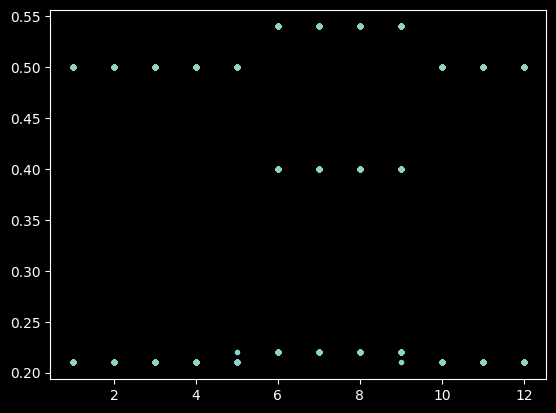

In [199]:
#the prices vary through the year:
plt.plot(pricingtime["Month"], pricingtime["Electricity Pricing [$]"] , ".")

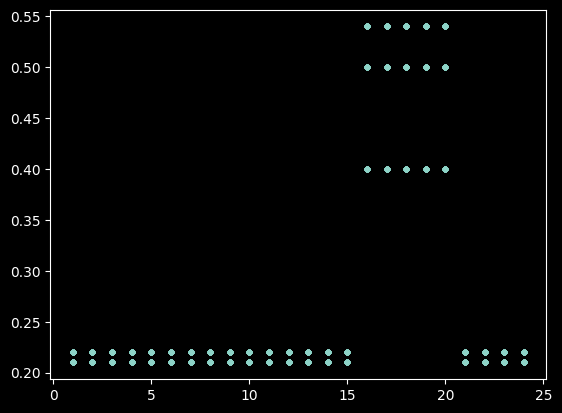

In [200]:
#the prices vary through the day:
plt.plot(pricingtime["Hour"], pricingtime["Electricity Pricing [$]"] , ".")

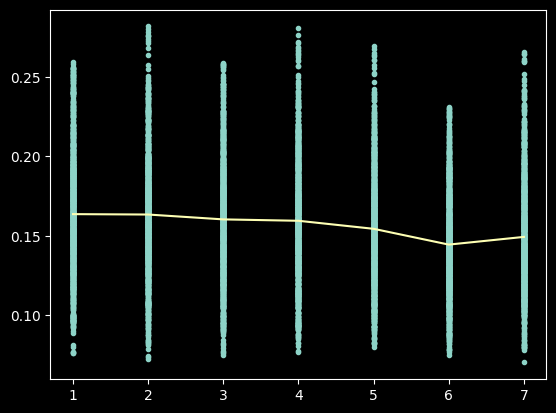

In [201]:
# The emmissions vary through the week:

plt.plot(pricingtime["Day Type"], pricingtime["kg_CO2/kWh"] , ".")
plt.plot(pricingtime.groupby(["Day Type"])["kg_CO2/kWh"].mean())

Hour
1.0     0.130318
2.0     0.128075
3.0     0.127263
4.0     0.128403
5.0     0.134720
6.0     0.145037
7.0     0.150872
8.0     0.156235
9.0     0.161553
10.0    0.164933
11.0    0.167179
12.0    0.167927
13.0    0.168712
14.0    0.169505
15.0    0.171147
16.0    0.174675
17.0    0.178359
18.0    0.179303
19.0    0.177764
20.0    0.175379
21.0    0.168057
22.0    0.153261
23.0    0.143484
24.0    0.134576
Name: kg_CO2/kWh, dtype: float64


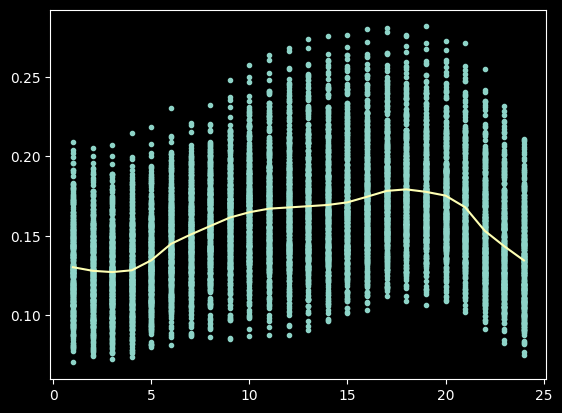

In [202]:
# The emmissions vary through the day:

plt.plot(pricingtime["Hour"], pricingtime["kg_CO2/kWh"] , ".")
plt.plot(pricingtime.groupby(["Hour"])["kg_CO2/kWh"].mean())
print(pricingtime.groupby(["Hour"])["kg_CO2/kWh"].mean())

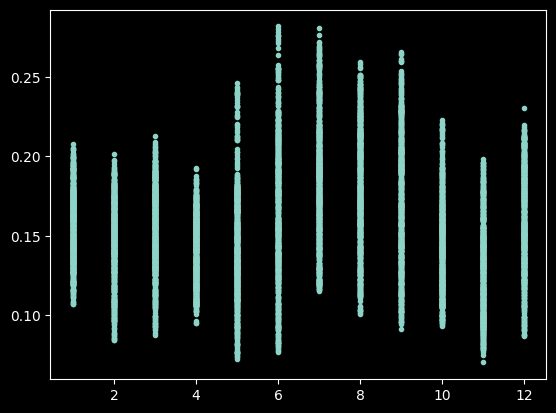

In [203]:
# The emmissions vary through the year:
plt.plot(pricingtime["Month"], pricingtime["kg_CO2/kWh"] , ".")

## Solar production and Electricity Demand:

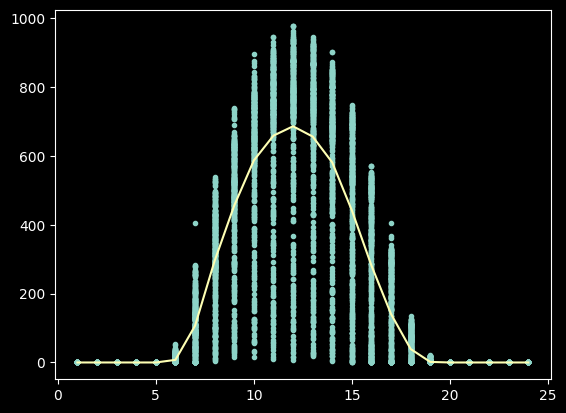

In [204]:
# solar production varies throughout the day:
plt.plot(building1["Hour"], building1["Solar Generation [W/kW]"] , ".")
plt.plot(building1.groupby(["Hour"])["Solar Generation [W/kW]"].mean())

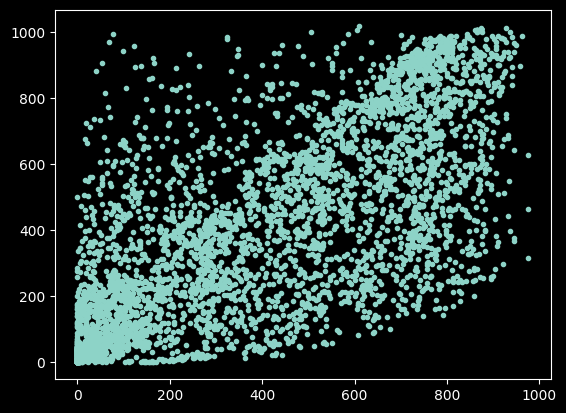

In [205]:
plt.scatter(x=building1["Solar Generation [W/kW]"], y=weather[diffuse], marker=".")

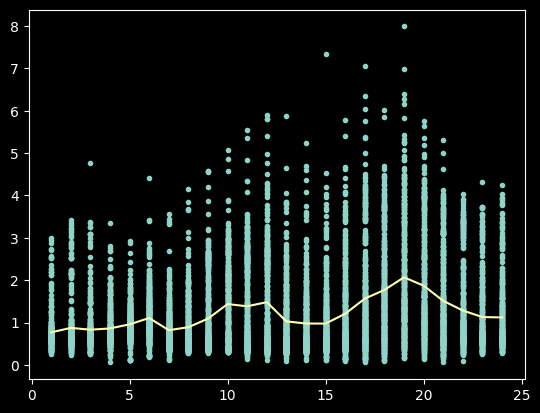

In [206]:
# Energy Use varies throughout the day:
plt.plot(building1["Hour"], building1["Equipment Electric Power [kWh]"] , ".")
plt.plot(building1.groupby(["Hour"])["Equipment Electric Power [kWh]"].mean())

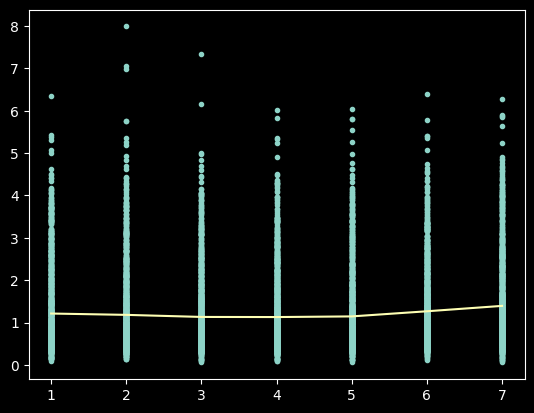

In [207]:
# Energy Use varies throughout the week:
plt.plot(building1["Day Type"], building1["Equipment Electric Power [kWh]"] , ".")
plt.plot(building1.groupby(["Day Type"])["Equipment Electric Power [kWh]"].mean())

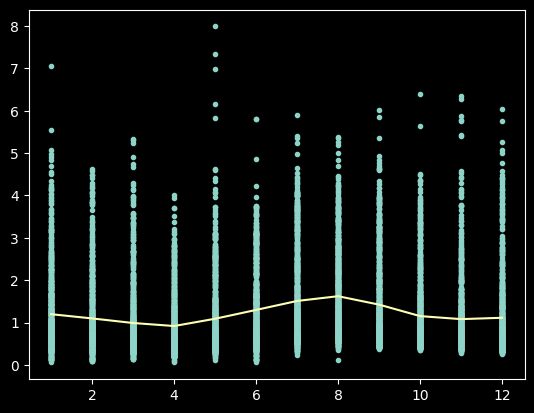

In [208]:
# Energy Use varies throughout the year:
plt.plot(building1["Month"], building1["Equipment Electric Power [kWh]"] , ".")
plt.plot(building1.groupby(["Month"])["Equipment Electric Power [kWh]"].mean())

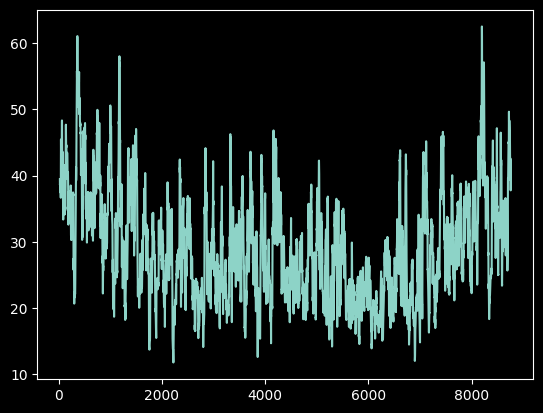

In [209]:

plt.plot(building1["Equipment Electric Power [kWh]"].rolling(24).sum())

## Investigating the reward function

In [210]:
net_load = {}
net_load["building1"] = ((building1["Equipment Electric Power [kWh]"] - (building1["Solar Generation [W/kW]"] * 4 / 1000)))
net_load["building2"] = ((building2["Equipment Electric Power [kWh]"] - (building2["Solar Generation [W/kW]"] * 4 / 1000)))
net_load["building3"] = ((building3["Equipment Electric Power [kWh]"] - (building3["Solar Generation [W/kW]"] * 4 / 1000)))
net_load["building4"] = ((building4["Equipment Electric Power [kWh]"] - (building4["Solar Generation [W/kW]"] * 4 / 1000)))
net_load["building5"] = ((building5["Equipment Electric Power [kWh]"] - (building5["Solar Generation [W/kW]"] * 4 / 1000)))

net_load = pd.DataFrame(net_load).clip(lower=0)

net_cost = [(net_load[c] * pricing["Electricity Pricing [$]"]).sum() for c in net_load] #net_loadmultiply(pricing["Electricity Pricing [$]"])

net_carbon = [(net_load[c] * co2["kg_CO2/kWh"]).sum() for c in net_load]


print("Net costs:",net_cost)
print("Net CO2 emissions:", net_carbon)
# print("Total cost in $",net_cost.sum())
# print("Total carbon emissions in kg", net_carbon.sum())

# These are the normalizing quotients. I think rewards are not normalized in the reward function.
# This means that the reward function gives more weight to price than to emissions reductions.

Net costs: [2250.8700563860034, 1966.1250130131689, 1315.5171066205235, 1875.906842689057, 1540.8814011827963]
Net CO2 emissions: [1117.6211690517193, 1043.3168421031762, 707.0223402007878, 1080.9376721533065, 791.53366612883]


## Investigating runs

,0
0,-3.397588
1,0.729818
2,0.664364
3,-7.282181
4,1.224344
...,...
8754,-10.196947
8755,-2.389318
8756,-4.655911
8757,-4.872134


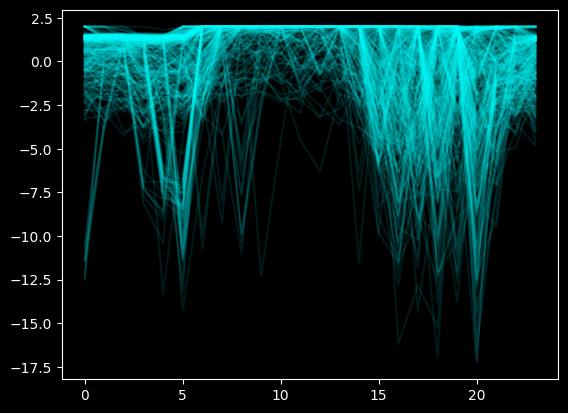

In [238]:
rewards = pd.read_csv("../rewards.csv", header=None)
for i in range(0, 8760, 24):
    plt.plot(rewards[i:i+24].values, alpha=0.1, color="cyan")
rewards

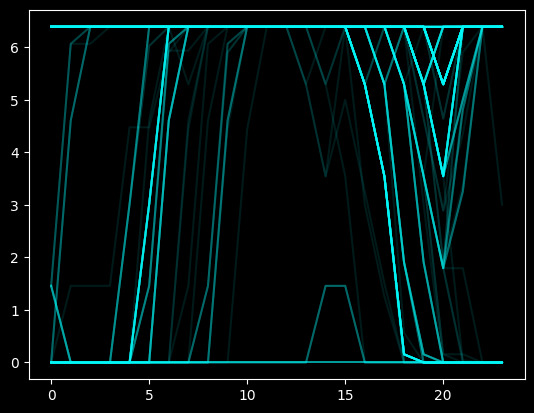

In [240]:
soc = pd.read_csv("../soc.csv", header=None)
for i in range(0, 8760, 24):
    plt.plot(soc[i:i+24].values, alpha=0.1, color="cyan")

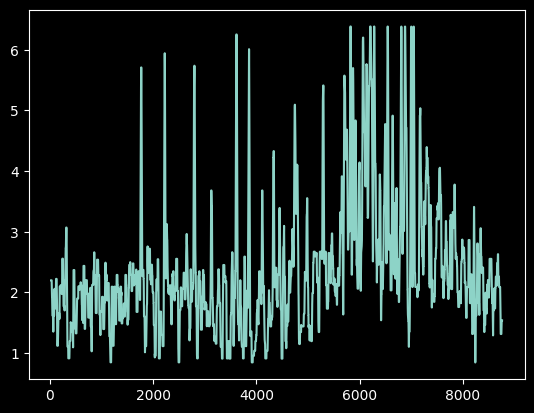

In [213]:
plt.plot(soc.rolling(24).mean())

0.0     333
1.0      93
2.0     590
3.0     381
4.0    1302
5.0    1257
6.0    1588
7.0    1154
8.0    2061
dtype: int64


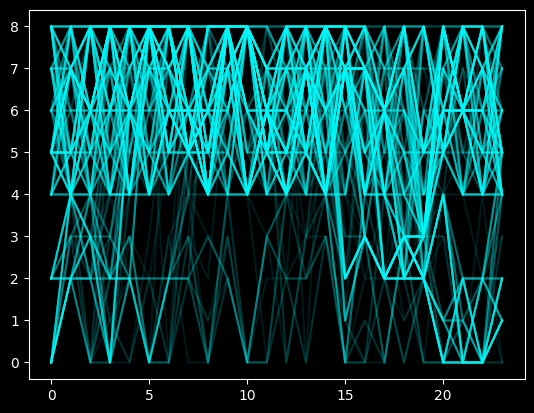

In [239]:
actions = pd.read_csv("../actions.csv",header=None)
print(actions.value_counts(sort=False))

for i in range(0, 8760, 24):
    plt.plot(actions[i:i+24].values, alpha=0.1, color="cyan")

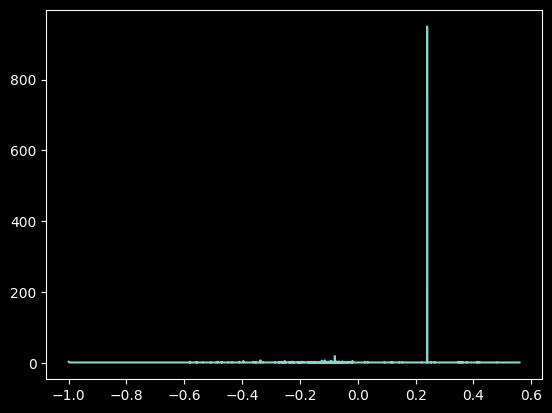

In [230]:
plt.plot(np.array([i for i in actions.value_counts(sort=False).index]), actions.value_counts(sort=False).values)

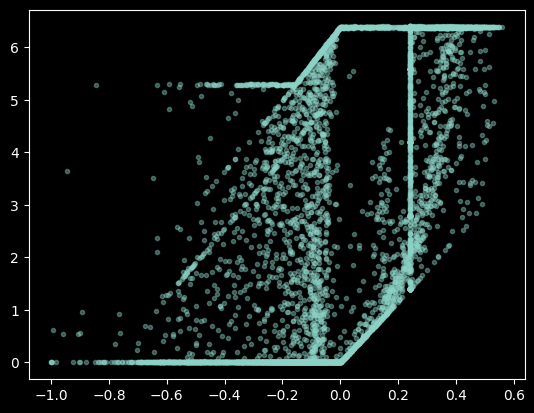

In [236]:
plt.scatter(x=actions, y=soc[1:], marker=".", alpha=0.4)

In [217]:
obs = pd.read_csv("../obs.csv",header=None)

(array([6934.,    0.,    0.,    0.,    0.,  170.,    0.,    0., 1215.,
         440.]),
 array([0.21 , 0.243, 0.276, 0.309, 0.342, 0.375, 0.408, 0.441, 0.474,
        0.507, 0.54 ]),
 <BarContainer object of 10 artists>)

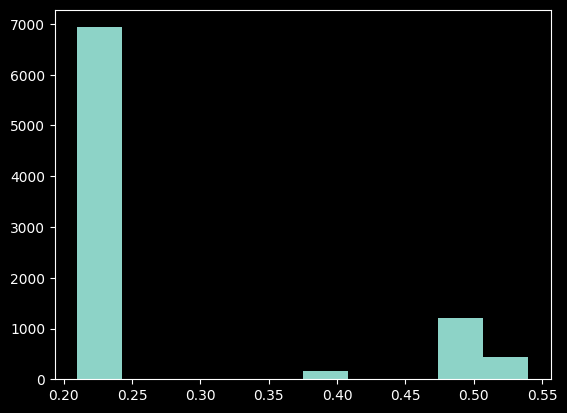

In [218]:
plt.hist(obs[25])

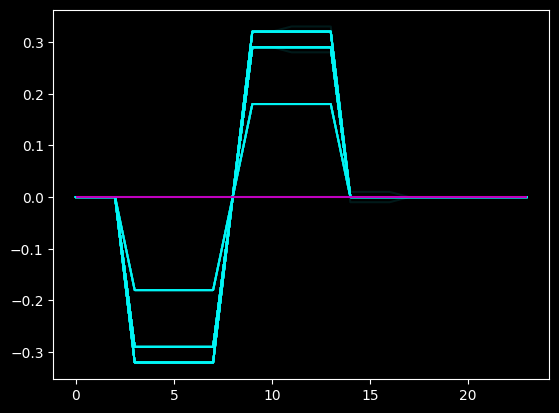

In [237]:
# the net demand without using the battery
net_demand = obs[25]-obs[26] #negative if solar > load
#net_demand= obs[20] - obs[21] # for full observations
for i in range(0, 8760, 24):
    plt.plot(net_demand[i:i+24].values, alpha=0.1, color="cyan")
plt.hlines(y=0, xmin=0, xmax=23, color="m")

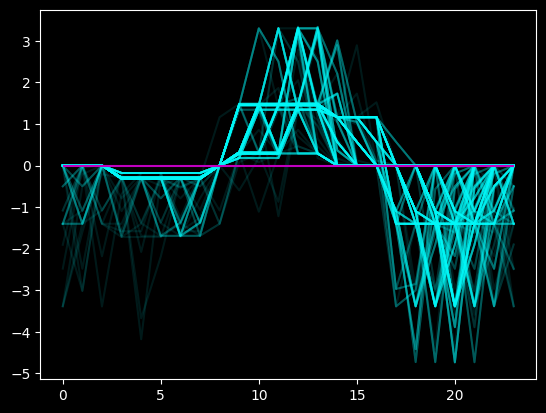

In [220]:
battery_demand=soc.diff()[0][1:]
total_demand = battery_demand + net_demand
for i in range(0, 8760, 24):
    plt.plot(total_demand.values[i:i+24], alpha=0.1, color="cyan")
plt.hlines(y=0, xmin=0, xmax=23, color="m")

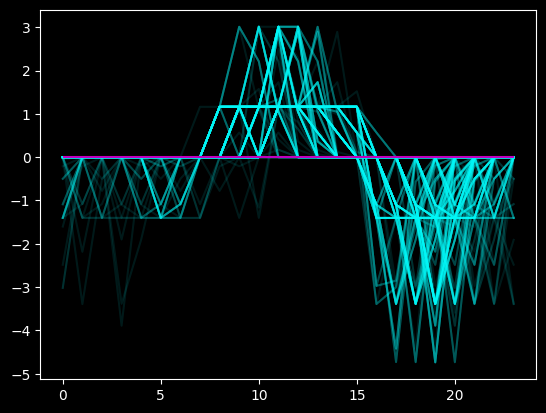

In [221]:
for i in range(0, 8760, 24):
    plt.plot(battery_demand.values[i:i+24], alpha=0.1, color="cyan")
plt.hlines(y=0, xmin=0, xmax=23, color="m")

In [222]:
print("Total demand (excl. battery):",net_demand[net_demand > 0].sum())
print("Total demand (incl. battery):",total_demand[total_demand > 0].sum())

Total demand (excl. battery): 523.7800000000001
Total demand (incl. battery): 2670.5994832000624


In [223]:
total_demand[total_demand > 0].sum()/net_demand[net_demand > 0].sum()

5.098704576730807

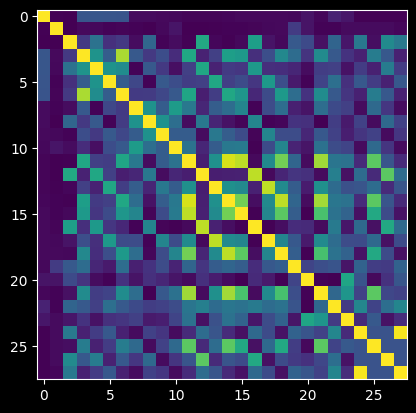

In [224]:
plt.imshow(obs.corr().abs())